In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# Data-reuploading classifier {#data_reuploading_classifier}

::: meta
:property=\"og:description\": Implement a single-qubit universal quantum
classifier using PennyLane. :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets/universal_dnn1.png>
:::

::: related
tutorial_variational_classifier Variational classifier
tutorial_multiclass_classification Multiclass margin classifier
tutorial_expressivity_fourier_series Quantum models as Fourier series
:::

*Author: Shahnawaz Ahmed --- Posted: 11 October 2019. Last updated: 19
January 2021.*

A single-qubit quantum circuit which can implement arbitrary unitary
operations can be used as a universal classifier much like a single
hidden-layered Neural Network. As surprising as it sounds,
[Pérez-Salinas et al. (2019)](https://arxiv.org/abs/1907.02085) discuss
this with their idea of \'data reuploading\'. It is possible to load a
single qubit with arbitrary dimensional data and then use it as a
universal classifier.

In this example, we will implement this idea with Pennylane - a python
based tool for quantum machine learning, automatic differentiation, and
optimization of hybrid quantum-classical computations.

## Background

We consider a simple classification problem and will train a
single-qubit variational quantum circuit to achieve this goal. The data
is generated as a set of random points in a plane $(x_1, x_2)$ and
labeled as 1 (blue) or 0 (red) depending on whether they lie inside or
outside a circle. The goal is to train a quantum circuit to predict the
label (red or blue) given an input point\'s coordinate.

![](../_static/demonstration_assets/data_reuploading/universal_circles.png)

### Transforming quantum states using unitary operations

A single-qubit quantum state is characterized by a two-dimensional state
vector and can be visualized as a point in the so-called Bloch sphere.
Instead of just being a 0 (up) or 1 (down), it can exist in a
superposition with say 30% chance of being in the $|0 \rangle$ and 70%
chance of being in the $|1 \rangle$ state. This is represented by a
state vector
$|\psi \rangle = \sqrt{0.3}|0 \rangle + \sqrt{0.7}|1 \rangle$ -the
probability \"amplitude\" of the quantum state. In general we can take a
vector $(\alpha, \beta)$ to represent the probabilities of a qubit being
in a particular state and visualize it on the Bloch sphere as an arrow.

![](../_static/demonstration_assets/data_reuploading/universal_bloch.png)

### Data loading using unitaries

In order to load data onto a single qubit, we use a unitary operation
$U(x_1, x_2, x_3)$ which is just a parameterized matrix multiplication
representing the rotation of the state vector in the Bloch sphere. E.g.,
to load $(x_1, x_2)$ into the qubit, we just start from some initial
state vector, $|0 \rangle,$ apply the unitary operation $U(x_1, x_2, 0)$
and end up at a new point on the Bloch sphere. Here we have padded 0
since our data is only 2D. Pérez-Salinas et al. (2019) discuss how to
load a higher dimensional data point ($[x_1, x_2, x_3, x_4, x_5, x_6]$)
by breaking it down in sets of three parameters
($U(x_1, x_2, x_3), U(x_4, x_5, x_6)$).

### Model parameters with data re-uploading

Once we load the data onto the quantum circuit, we want to have some
trainable nonlinear model similar to a neural network as well as a way
of learning the weights of the model from data. This is again done with
unitaries, $U(\theta_1, \theta_2, \theta_3),$ such that we load the data
first and then apply the weights to form a single layer
$L(\vec \theta, \vec x) = U(\vec \theta)U(\vec x).$ In principle, this
is just application of two matrix multiplications on an input vector
initialized to some value. In order to increase the number of trainable
parameters (similar to increasing neurons in a single layer of a neural
network), we can reapply this layer again and again with new sets of
weights,
$L(\vec \theta_1, \vec x) L(\vec \theta_2, , \vec x) ... L(\vec \theta_L, \vec x)$
for $L$ layers. The quantum circuit would look like the following:

![](../_static/demonstration_assets/data_reuploading/universal_layers.png)

### The cost function and \"nonlinear collapse\"

So far, we have only performed linear operations (matrix
multiplications) and we know that we need to have some nonlinear
squashing similar to activation functions in neural networks to really
make a universal classifier (Cybenko 1989). Here is where things gets a
bit quantum. After the application of the layers, we will end up at some
point on the Bloch sphere due to the sequence of unitaries implementing
rotations of the input. These are still just linear transformations of
the input state. Now, the output of the model should be a class label
which can be encoded as fixed vectors (Blue = $[1, 0],$ Red = $[0, 1]$)
on the Bloch sphere. We want to end up at either of them after
transforming our input state through alternate applications of data
layer and weights.

We can use the idea of the \"collapse\" of our quantum state into one or
other class. This happens when we measure the quantum state which leads
to its projection as either the state 0 or 1. We can compute the
fidelity (or closeness) of the output state to the class label making
the output state jump to either $| 0 \rangle$ or $|1\rangle.$ By
repeating this process several times, we can compute the probability or
overlap of our output to both labels and assign a class based on the
label our output has a higher overlap. This is much like having a set of
output neurons and selecting the one which has the highest value as the
label.

We can encode the output label as a particular quantum state that we
want to end up in and use Pennylane to find the probability of ending up
in that state after running the circuit. We construct an observable
corresponding to the output label using the
[Hermitian](https://pennylane.readthedocs.io/en/latest/code/ops/qubit.html#pennylane.ops.qubit.Hermitian)
operator. The expectation value of the observable gives the overlap or
fidelity. We can then define the cost function as the sum of the
fidelities for all the data points after passing through the circuit and
optimize the parameters $(\vec \theta)$ to minimize the cost.

$$\texttt{Cost} = \sum_{\texttt{data points}} (1 - \texttt{fidelity}(\psi_{\texttt{output}}(\vec x, \vec \theta), \psi_{\texttt{label}}))$$

Now, we can use our favorite optimizer to maximize the sum of the
fidelities over all data points (or batches of datapoints) and find the
optimal weights for classification. Gradient-based optimizers such as
Adam (Kingma et. al., 2014) can be used if we have a good model of the
circuit and how noise might affect it. Or, we can use some gradient-free
method such as L-BFGS (Liu, Dong C., and Nocedal, J., 1989) to evaluate
the gradient and find the optimal weights where we can treat the quantum
circuit as a black-box and the gradients are computed numerically using
a fixed number of function evaluations and iterations. The L-BFGS method
can be used with the PyTorch interface for Pennylane.

### Multiple qubits, entanglement and Deep Neural Networks

The Universal Approximation Theorem declares that a neural network with
two or more hidden layers can serve as a universal function
approximator. Recently, we have witnessed remarkable progress of
learning algorithms using Deep Neural Networks.

Pérez-Salinas et al. (2019) make a connection to Deep Neural Networks by
describing that in their approach the \"layers\"
$L_i(\vec \theta_i, \vec x )$ are analogous to the size of the
intermediate hidden layer of a neural network. And the concept of deep
(multiple layers of the neural network) relates to the number of qubits.
So, multiple qubits with entanglement between them could provide some
quantum advantage over classical neural networks. But here, we will only
implement a single qubit classifier.

![](../_static/demonstration_assets/data_reuploading/universal_dnn.png)

## \"Talk is cheap. Show me the code.\" - Linus Torvalds


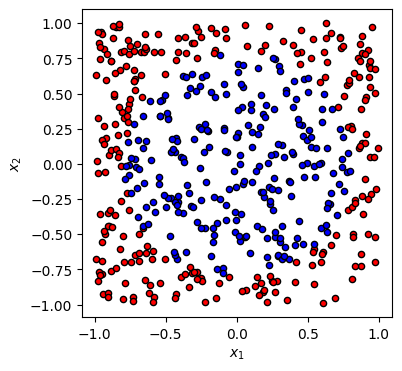

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

# Simple classifier with data reloading and fidelity loss


In [3]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

# Utility functions for testing and creating batches


In [4]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

# Train a quantum classifier on the circle dataset


In [5]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.372070 | Train accuracy: 0.425000 | Test Accuracy: 0.490500
Epoch:  1 | Loss: 0.283152 | Train accuracy: 0.585000 | Test accuracy: 0.595000
Epoch:  2 | Loss: 0.317001 | Train accuracy: 0.550000 | Test accuracy: 0.568000
Epoch:  3 | Loss: 0.106586 | Train accuracy: 0.895000 | Test accuracy: 0.837000
Epoch:  4 | Loss: 0.167625 | Train accuracy: 0.765000 | Test accuracy: 0.769000
Epoch:  5 | Loss: 0.112176 | Train accuracy: 0.830000 | Test accuracy: 0.747500
Epoch:  6 | Loss: 0.113650 | Train accuracy: 0.870000 | Test accuracy: 0.782500


KeyboardInterrupt: 

# Results


In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# References

\[1\] Pérez-Salinas, Adrián, et al. \"Data re-uploading for a universal
quantum classifier.\" arXiv preprint arXiv:1907.02085 (2019).

\[2\] Kingma, Diederik P., and Ba, J. \"Adam: A method for stochastic
optimization.\" arXiv preprint arXiv:1412.6980 (2014).

\[3\] Liu, Dong C., and Nocedal, J. \"On the limited memory BFGS method
for large scale optimization.\" Mathematical programming 45.1-3 (1989):
503-528.

# About the author
